In [1]:
from dataloader import RetinopathyDataset
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models
from torchvision import transforms
import pyprind

In [2]:
from IPython.display import clear_output

In [3]:
train_dataset = RetinopathyDataset('./data', 'train')
test_dataset = RetinopathyDataset('./data', 'test')

augmentation = [
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
]
train_dataset_with_augementation = RetinopathyDataset('./data', 'train', augmentation=augmentation)

> Found 28099 images...
> Found 7025 images...
> Found 28099 images...


In [4]:
class BasicBlock(nn.Module):
    '''
    x = (in, H, W) -> conv2d -> (out, H, W) -> conv2d -> (out, H, W) + x
    '''
    expansion = 1
    
    def __init__(self, in_channels, out_channels, stride=1, kernel_size=3, downsample=None):
        super(BasicBlock, self).__init__()
        padding = int(kernel_size/2)
        self.activation = nn.ReLU(inplace=True)
        self.block = nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels, 
                kernel_size=kernel_size, padding=padding, stride=stride, bias=False
            ),
            nn.BatchNorm2d(out_channels),
            self.activation,
            nn.Conv2d(
                out_channels, out_channels, 
                kernel_size=kernel_size, padding=padding, bias=False
            ),
            nn.BatchNorm2d(out_channels),
        )
        self.downsample = downsample
        
    def forward(self, x):
        residual = x
        out = self.block(x)
        
        if self.downsample is not None:
            residual = self.downsample(x)
        
        out += residual
        out = self.activation(out)
        
        return out

class BottleneckBlock(nn.Module):
    '''
    x = (in, H, W) -> conv2d(1x1) -> conv2d -> (out, H, W) -> conv2d(1x1) -> (out*4, H, W) + x 
    '''
    expansion = 4
    
    def __init__(self, in_channels, out_channels, stride=1, kernel_size=3, downsample=None):
        super(BottleneckBlock, self).__init__()
        padding = int(kernel_size/2)
        self.activation = nn.ReLU(inplace=True)
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            self.activation,
            nn.Conv2d(
                out_channels, out_channels,
                kernel_size=kernel_size, stride=stride, padding=padding, bias=False
            ),
            nn.BatchNorm2d(out_channels),
            self.activation,
            nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels * self.expansion),
        )
        self.downsample = downsample
    
    def forward(self, x):
        residual = x
        out = self.block(x)
        
        if self.downsample is not None:
            residual = self.downsample(x)
        
        out += residual
        out = self.activation(out)
        
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes, start_in_channels=64):
        super(ResNet, self).__init__()
        
        self.current_in_channels = start_in_channels
        
        self.first = nn.Sequential(
            nn.Conv2d(
                3, self.current_in_channels,
                kernel_size=7, stride=2, padding=3, bias=False
            ),
            nn.BatchNorm2d(self.current_in_channels),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )
        
        self.layers = layers
        channels = self.current_in_channels
        for i, l in enumerate(layers):
            setattr(self, 'layer'+str(i+1), 
                    self._make_layer(block, channels, l, stride=(2 if i!=0 else 1) ))
            channels*=2
        
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(self.current_in_channels, num_classes)
            
    def _make_layer(self, block, in_channels, blocks, stride=1):
        downsample=None
        if stride != 1 or self.current_in_channels != in_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(
                    self.current_in_channels, in_channels * block.expansion,
                    kernel_size = 1, stride=stride, bias=False
                ),
                nn.BatchNorm2d(in_channels * block.expansion)
            )
        
        layers = []
        layers.append(block(self.current_in_channels, in_channels, stride=stride, downsample=downsample))
        self.current_in_channels = in_channels * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.current_in_channels, in_channels))
        
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.first(x)
        for i in range(len(self.layers)):
            x = getattr(self, 'layer'+str(i+1))(x)
        x = self.avgpool(x)
        # flatten
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        
        return x

In [5]:
class PretrainResNet(nn.Module):
    def __init__(self, num_classes, num_layers):
        super(PretrainResNet, self).__init__()
        
        pretrained_model = torchvision.models.__dict__[
            'resnet{}'.format(num_layers)](pretrained=True)
        
        self.conv1 = pretrained_model._modules['conv1']
        self.bn1 = pretrained_model._modules['bn1']
        self.relu = pretrained_model._modules['relu']
        self.maxpool = pretrained_model._modules['maxpool']

        self.layer1 = pretrained_model._modules['layer1']
        self.layer2 = pretrained_model._modules['layer2']
        self.layer3 = pretrained_model._modules['layer3']
        self.layer4 = pretrained_model._modules['layer4']
        
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(
            pretrained_model._modules['fc'].in_features, num_classes
        )
                
        del pretrained_model
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        # print(x.shape)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        
        return x

In [6]:
def ResNet18(pre_train=False):
    if pre_train:
        return PretrainResNet(num_classes=5, num_layers=18)
    return ResNet(BasicBlock, layers=[2,2,2,2], num_classes=5)
def ResNet50(pre_train=False):
    if pre_train:
        return PretrainResNet(num_classes=5, num_layers=50)
    return ResNet(BottleneckBlock, layers=[3,4,6,3], num_classes=5)

In [7]:
def showAccuracy(title='', accline=[75, 82], **kwargs):
    fig = plt.figure(figsize=(8,4.5))
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy(%)')
    
    for label, data in kwargs.items():
        plt.plot(
            range(1, len(data)+1), data, 
            '--' if 'test' in label else '-', 
            label=label
        )
    
    plt.legend(
        loc='best', bbox_to_anchor=(1.0, 1.0, 0.2, 0),
        fancybox=True, shadow=True
    )
    
    if accline:
        plt.hlines(accline, 1, len(data)+1, linestyles='dashed', colors=(0,0,0,0.8))
    
    plt.show()
    
    return fig

In [25]:
def evalModels(models, test_loader, testing_mode=False, return_y=False):
    test_correct = {key:0.0 for key in models}
    if return_y:
        y_pred = {key:torch.Tensor([]).long() for key in models}
        y_true = torch.Tensor([]).long()
    bar = pyprind.ProgPercent(len(test_loader.dataset), title="Testing epoch : ")
    for model in models.values():
        model.train(testing_mode)
    with torch.no_grad():
        for idx, data in enumerate(test_loader):
            x, y = data
            inputs = x.to(device)
            labels = y.to(device)
            
            if return_y:
                y_true =torch.cat((y_true, y.long().view(-1)))
            
            for key, model in models.items():
                outputs = model(inputs)
        
                test_correct[key] += (
                    torch.max(outputs, 1)[1] == labels.long().view(-1)
                ).sum().item()
                
                if return_y:
                    y_pred[key] = torch.cat((y_pred[key], torch.max(outputs, 1)[1].to(torch.device('cpu')).long()))
                
            
            bar.update(test_loader.batch_size)
            #clear_output(wait=True)
            #print('Testing batch : {:.3f} %'.format(
            #    ((idx+1)*test_loader.batch_size*100) / len(test_loader.dataset)
            #))
    if return_y:
        return test_correct, y_true, y_pred
    else:
        return test_correct

In [26]:
def runModels(
    name, train_dataset, test_dataset, models, epoch_size, batch_size, learning_rate, 
    optimizer = optim.SGD, optimizer_option = {'momentum':0.9, 'weight_decay':5e-4}, 
    criterion = nn.CrossEntropyLoss(),
    show = True, testing_mode=False, callback=None
):
    train_loader = DataLoader(train_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    
    accs, pre_epoch = load_running_state(name, models)
    
    if accs is None:
        accs = {
            **{key+"_train" : [] for key in models},
            **{key+"_test" : [] for key in models}
        }
    if pre_epoch is None:
        pre_epoch = 0
    else:
        pre_epoch += 1
    
    if show:
        showAccuracy(
            title='Epoch [{:4d}]'.format(pre_epoch),
            **accs
        )
    
    optimizers = {
        key: optimizer(value.parameters(), lr=learning_rate, **optimizer_option) 
        for key, value in models.items()
    }
    for epoch in range(pre_epoch, epoch_size):
        bar = pyprind.ProgPercent(len(train_dataset), title="Training epoch {} : ".format(epoch+1))
        
        train_correct = {key:0.0 for key in models}
        test_correct = {key:0.0 for key in models}
        # training multiple model
        for model in models.values():
            model.train()
        
        for idx, data in enumerate(train_loader):
            x, y = data
            inputs = x.to(device)
            labels = y.to(device).long().view(-1)
        
            for optimizer in optimizers.values():
                optimizer.zero_grad()
        
            for key, model in models.items():
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                
                cur_correct = (
                    torch.max(outputs, 1)[1] == labels
                ).sum().item()
            
                train_correct[key] += cur_correct
        
            for optimizer in optimizers.values():
                optimizer.step()
            
            bar.update(batch_size)
            #clear_output(wait=True)
            #print('Training batch : {:.3f} %'.format(((idx+1)*batch_size*100) / len(train_dataset)))
        
        # testing multiple model
        test_correct = evalModels(
            models, test_loader, 
            testing_mode=testing_mode
        )

        for key, value in train_correct.items():
            accs[key+"_train"] += [(value*100.0) / len(train_dataset)]
    
        for key, value in test_correct.items():
            accs[key+"_test"] += [(value*100.0) / len(test_dataset)]
         
        if show:
            clear_output(wait=True)
            showAccuracy(
                title='Epoch [{:4d}]'.format(epoch + 1),
                **accs
            )
        
        # epoch end
        torch.cuda.empty_cache()
        save_running_state(name, models, accs, epoch)
        if callback:
            callback(models, accs)
    
    return accs
Accs = {}

In [10]:
def save_running_state(name, models, accs, epoch, root='./result'):
    if not os.path.isdir(root):
        os.mkdir(root)
    root = os.path.join(root, name)
    if not os.path.isdir(root):
        os.mkdir(root)
    p = os.path.join(root, 'state.pkl')
    save_model(models, root)
    
    state = {'accs' : accs, 'epoch':epoch }
    torch.save(state, p)
        
        
def load_running_state(name, models, root='./result'):
    root = os.path.join(root, name)
    p = os.path.join(root, 'state.pkl')
    if not os.path.isfile(p):
        return None, None
    
    load_model(models, root)
    
    state = torch.load(p)
    accs = state['accs']
    epoch = state['epoch']
    return accs, epoch

In [11]:
def __save_model(model_name, model, root):
    if not os.path.isdir(root):
        os.mkdir(root)
    p = os.path.join(root, '{}-params.pkl'.format(model_name))
    torch.save(model.state_dict(), p)
    return p

def save_model(models, root='./model'):
    p = {}
    for k, m in models.items():
        p[k] = __save_model(k, m, root)
    return p

def __load_model(model_name, model, root):
    p = os.path.join(root, '{}-params.pkl'.format(model_name))
    if not os.path.isfile(p):
        raise AttributeError(
            "No model parameters file for {}!".format(model_name)
        )
    paras = torch.load(p)
    model.load_state_dict(paras)

def load_model(models, root='./model'):
    for k, m in models.items():
        __load_model(k, m, root)
        
def save_image(fig, title, root):
    fig.savefig(
        fname=os.path.join(root, title + '.png'),
        dpi=300,
        metadata = {
            'Title': title,
            'Author': '0756110',
        },
        bbox_inches="tight",
    )
    
def save_accuracy(name, models, accs, root='./result'):
    if not os.path.isdir(root):
        os.mkdir(root)
    root = os.path.join(root, name)
    if not os.path.isdir(root):
        os.mkdir(root)
    fig = showAccuracy(
        title=name,
        **accs
    )
    save_image(fig, title=name, root=root)
    p = os.path.join(root, name+'_accuracy.pkl')
    torch.save(accs, p)

In [20]:
# create model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
models = {
    "ResNet18" : ResNet18().to(device),
    "ResNet18(pretrain)": ResNet18(pre_train=True).to(device),
}

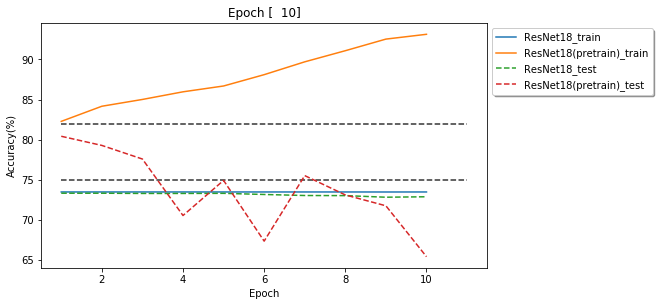

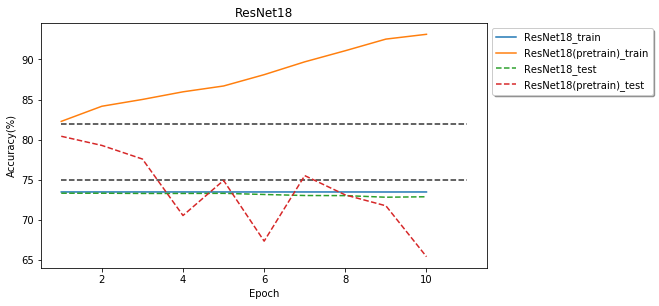

CPU times: user 13h 28min 47s, sys: 19min 20s, total: 13h 48min 7s
Wall time: 1h 43min 30s


In [21]:
%%time
# Training & Testing
name = 'ResNet18'
Accs[name] = runModels(
    name, train_dataset, test_dataset, models,
    epoch_size=10, batch_size=4, learning_rate=1e-3, show=True)
fig = showAccuracy(
    title=name,
    **Accs[name]
)

In [16]:
# create model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
models = {
    "ResNet18" : ResNet18().to(device),
    "ResNet18(pretrain)": ResNet18(pre_train=True).to(device),
}

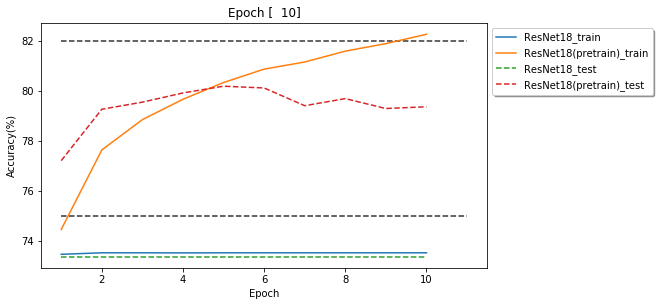

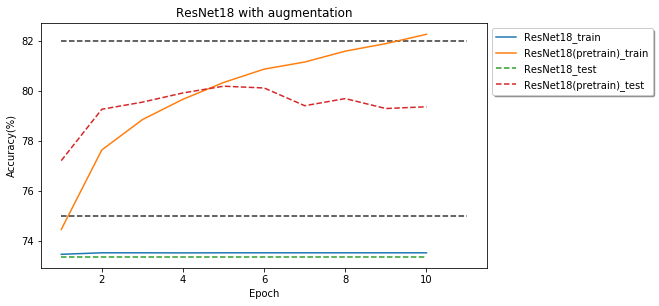

CPU times: user 450 ms, sys: 69.2 ms, total: 519 ms
Wall time: 519 ms


In [34]:
%%time
# Training & Testing
name = 'ResNet18 with augmentation'
Accs[name] = runModels(
    name, train_dataset_with_augementation, test_dataset, models, 
    epoch_size=10, batch_size=4, learning_rate=1e-3, show=True)
fig = showAccuracy(
    title=name,
    **Accs[name]
)

In [17]:
# create model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
models = {
    "ResNet18" : ResNet18().to(device),
    "ResNet18(pretrain)": ResNet18(pre_train=True).to(device),
}

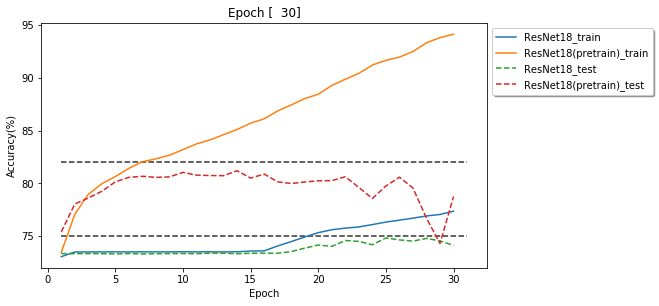

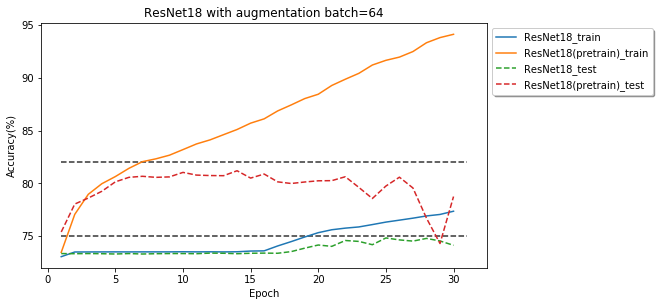

CPU times: user 6h 9min 15s, sys: 28min 7s, total: 6h 37min 23s
Wall time: 1h 51min 8s


In [20]:
%%time
# Training & Testing
name = 'ResNet18 with augmentation batch=64'
Accs[name] = runModels(
    name, train_dataset_with_augementation, test_dataset, models, 
    epoch_size=30, batch_size=64, learning_rate=1e-3, show=True)
fig = showAccuracy(
    title=name,
    **Accs[name]
)

In [12]:
# create model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
models = {
    "ResNet50" : ResNet50().to(device),
    "ResNet50(pretrain)": ResNet50(pre_train=True).to(device),
}

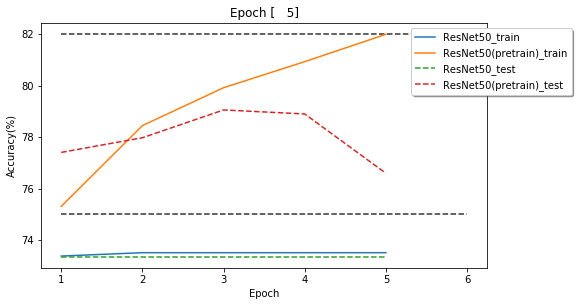

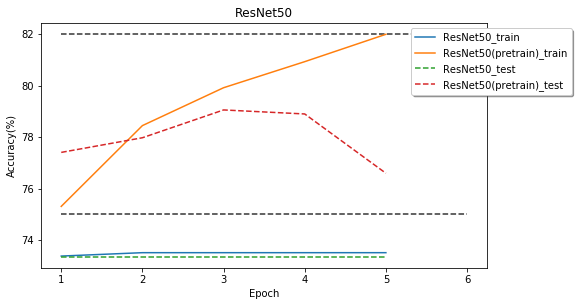

CPU times: user 17h 11min 34s, sys: 27min 47s, total: 17h 39min 21s
Wall time: 2h 12min 25s


In [14]:
%%time
# Training & Testing
name = 'ResNet50'
Accs[name] = runModels(
    name, train_dataset, test_dataset, models,
    epoch_size=5, batch_size=4, learning_rate=1e-3, show=True
)
fig = showAccuracy(
    title=name,
    **Accs[name]
)

In [12]:
# create model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
models = {
    "ResNet50" : ResNet50().to(device),
    "ResNet50(pretrain)": ResNet50(pre_train=True).to(device),
}

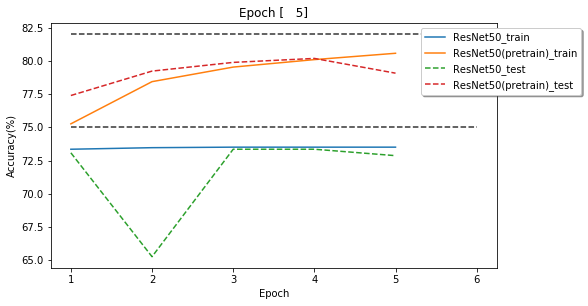

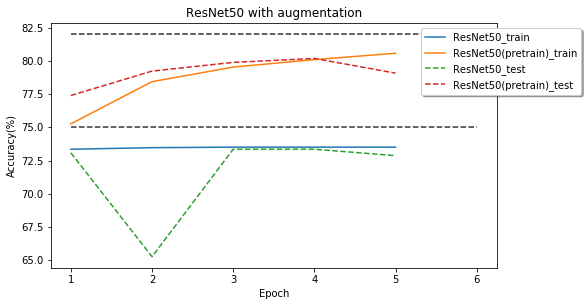

CPU times: user 300 ms, sys: 26.7 ms, total: 326 ms
Wall time: 325 ms


In [13]:
%%time
# Training & Testing
name = 'ResNet50 with augmentation'
Accs[name] = runModels(
    name, train_dataset_with_augementation, test_dataset, models,
    epoch_size=5, batch_size=4, learning_rate=1e-3, show=True
)
fig = showAccuracy(
    title=name,
    **Accs[name]
)

In [37]:
# create model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
models = {
    "ResNet50" : ResNet50().to(device),
    "ResNet50(pretrain)": ResNet50(pre_train=True).to(device),
}

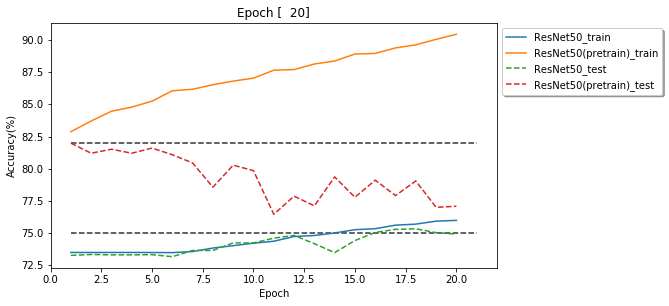

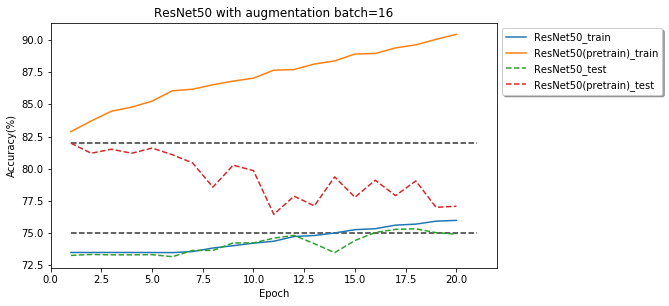

CPU times: user 288 ms, sys: 61.4 ms, total: 350 ms
Wall time: 348 ms


In [43]:
%%time
# Training & Testing
name = 'ResNet50 with augmentation batch=16'
Accs[name] = runModels(
    name, train_dataset_with_augementation, test_dataset, models,
    epoch_size=20, batch_size=16, learning_rate=1e-3, show=True
)
fig = showAccuracy(
    title=name,
    **Accs[name]
)

In [ ]:
%%time
# create model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
models = {
    #"ResNet18(pretrain)": ResNet18(pre_train=True).to(device),
    "ResNet50(pretrain)": ResNet50(pre_train=True).to(device),
}
# Training & Testing
name = 'ResNet Highest Accuracy 3'

def saveHighAcc(models, accs):
    for k in models.keys():
        if accs[k+'_test'][-1] >= max(accs[k+'_test']):
            __save_model(k, models[k], root='./highAccuracy')

def loadHighAcc(models):
    for k in models.keys():
        __load_model(k, models[k], root='./highAccuracy')


Accs[name] = runModels(
    name, train_dataset_with_augementation, test_dataset, models,
    epoch_size=10, batch_size=16, learning_rate=1e-3, show=True, callback=saveHighAcc
)
fig = showAccuracy(
    title=name,
    **Accs[name]
)

In [51]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
def plot_confusion_matrix(
    y_true, y_pred, classes,
    normalize=False, title=None, cmap=plt.cm.Blues
):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        #print('Confusion matrix, without normalization')
        pass

    #print(cm)

    fig = plt.figure(figsize=(8,8))
    ax = plt.gca()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [61]:
loadHighAcc(models)

In [62]:
a, b, c = evalModels(models, test_loader = DataLoader(test_dataset, batch_size=4), return_y=True)

Testing epoch : 
[100 %] Time elapsed: 00:01:23 | ETA: 23:59:59
Total time elapsed: 00:01:23


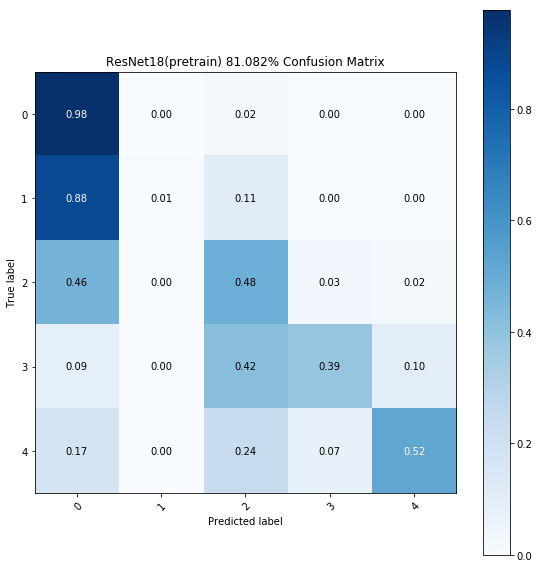

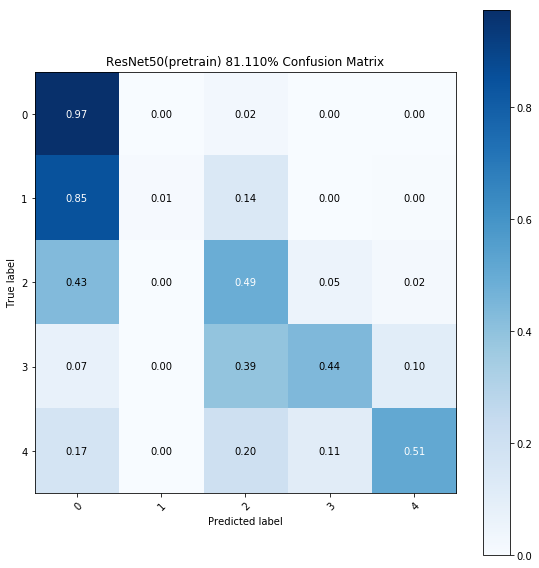

In [60]:
for k in c:
    d = float( (c[k] == b).sum() * 100 ) / len(test_dataset)
    plot_confusion_matrix(y_true=b, y_pred=c[k], title='{} {:.3f}% Confusion Matrix'.format(k, d), normalize=True, classes=np.array(['0', '1', '2', '3', '4']))

In [18]:
root = './result'
for n in os.listdir(root):
    a = os.path.join(root, n)
    p = os.path.join(a, 'state.pkl')
    
    if not os.path.isfile(p):
        continue
    
    state = torch.load(p)
    accs = state['accs']
    epoch = state['epoch']
    print('---')
    print(n)
    for k in accs:
        if not 'test' in k:
            continue
        print(k, ':', max(accs[k]))
    
    print('---')

---
ResNet50
ResNet50_test : 73.35231316725978
ResNet50(pretrain)_test : 79.06049822064057
---
---
ResNet50 with augmentation batch=16
ResNet50_test : 75.34519572953737
ResNet50(pretrain)_test : 81.99288256227759
---
---
ResNet18 with augmentation batch=64
ResNet18_test : 74.83274021352314
ResNet18(pretrain)_test : 81.20996441281139
---
---
ResNet18
ResNet18_test : 73.35231316725978
ResNet18(pretrain)_test : 80.44128113879003
---
---
ResNet Highest Accuracy
ResNet18(pretrain)_test : 81.08185053380782
ResNet50(pretrain)_test : 81.42348754448399
---
---
ResNet50 with augmentation
ResNet50_test : 73.35231316725978
ResNet50(pretrain)_test : 80.18505338078292
---
---
ResNet18 with augmentation
ResNet18_test : 73.35231316725978
ResNet18(pretrain)_test : 80.19928825622776
---
